# FRQI Implementation
From the following [paper](https://link.springer.com/article/10.1007/s11128-010-0177-y)

In [188]:
from commons import *
import math
from qiskit.circuit.library.standard_gates import RYGate
from qiskit.visualization import plot_histogram
import numpy as np
from PIL import Image

In [455]:
def coord2bool(i,j,N):
    '''
    (i,j) entry in NxN matrix
    0<= i,j <= N-1
    '''
    get_bin = lambda x, n: format(x, 'b').zfill(n)
    pad = len(get_bin(N*(N-1)+(N-1),0))
    
    return get_bin(N*i+j, pad)

def populate(counts, N):
    '''
    populate counts with states that yielded 0 shots
    '''
    for i in range(2**N):
        bnry = "{0:b}".format(i).zfill(N)
        if bnry not in counts:
            counts[bnry] = 0
    
    return counts

def my_acos(x):
    if(x>1):
        return 0
    return math.acos(x)

def counts2angles(counts):
    '''
    convert shot counts to probabilities and then to 
    angles encoding grayscale values
    '''
    
    shots = sum(counts.values())
    counts = [(k,v/shots) for k,v in counts.items() if k[-1]=='0'] 
    angles = [(k[:-1][::-1], my_acos(np.sqrt((2**(Nqs))*v))/(np.pi/2)) for k,v in counts]
    angles = sorted(angles, key=lambda x: int(x[0], 2))
    angles = np.array([v for k,v in angles]).reshape(N,N)
    
    return angles

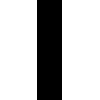

In [564]:
# Test image: NxN BW gradient
N=8

# gradient between 0 and 1 for N*N
#array = np.linspace(0,1,N*N)
#mat = np.reshape(array,(N,N))

a = np.zeros(N)
a[4], a[3] = 1, 1
mat = 1 -  a * np.ones((N,N))

# Creates PIL image
img = Image.fromarray(np.uint8(mat * 255) , 'L')
display(img.resize((100, 100),  Image.NEAREST))

In [565]:
# Number of qubits required to sufficiently store the NxN pixel positions 
Nqs = math.ceil(np.log2(N*N))

# +1 qubit encoding grayscale value
qc = QuantumCircuit(Nqs+1,Nqs+1)

# We require NxN angles to encode shade of each pixel
angles = [Parameter('$t_{}$'.format(i)) for i in range(N*N)]
angles = np.array(angles).reshape(N,N)

# Apply FRQI algorithm: https://link.springer.com/article/10.1007/s11128-010-0177-y

qc.h(range(1,Nqs+1))

# Apply Rys(T_i) for the ith pixel in the NxN image 
for i in range(N):
    for j in range(N):
        r = RYGate(angles[i][j])
        r = r.control(Nqs, ctrl_state=coord2bool(i,j,N))
        qc.append(r,list(range(0,Nqs+1))[::-1])

angle_values = dict(zip(angles.reshape(N*N), 2*(np.pi/2)*mat.reshape(N*N)))
qc = qc.assign_parameters(angle_values)
qc.measure(np.arange(0,Nqs+1),np.arange(0,Nqs+1));

In [ ]:
qc.draw('mpl')

In [567]:
shots = 1e4
backend = Aer.get_backend('qasm_simulator')
job =  execute(qc, backend, shots=shots)
counts = job.result().get_counts(qc)

In [568]:
counts = populate(counts, Nqs+1)

In [569]:
# retrieve angles and thus greyscale values from counts
angles_rec = counts2angles(counts)

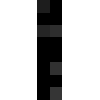

In [570]:
img_rec = Image.fromarray(np.uint8(angles_rec * 255) , 'L')
display(img_rec.resize((100, 100),  Image.NEAREST))
(img_rec.resize((100, 100),  Image.NEAREST)).save("images/stripe_rec.jpg")

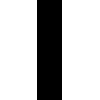

In [571]:
img = Image.fromarray(np.uint8(mat * 255) , 'L')
display(img.resize((100, 100),  Image.NEAREST))
(img.resize((100, 100),  Image.NEAREST)).save("images/stripe.jpg")

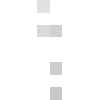

In [572]:
# get error
error = Image.fromarray(np.uint8((1-abs(angles_rec- mat)) * 255) , 'L')
display(error.resize((100, 100),  Image.NEAREST))
(error.resize((100, 100),  Image.NEAREST)).save("images/error_stripe.jpg")

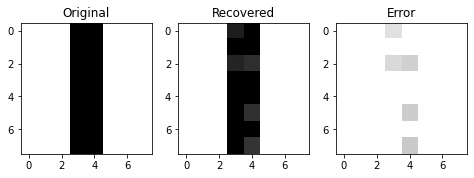

In [574]:
fig = plt.figure(figsize=(8,3))
columns = 3
rows = 1
for (i,imges,title) in zip(range(1, columns*rows +1), [img, img_rec, error], ["Original", "Recovered", "Error"]):
    fig.add_subplot(rows, columns, i)
    plt.imshow(imges, cmap='gray', vmin=0, vmax=255)
    plt.title(title)

plt.savefig("images/comparison_stripe.jpg")
plt.show()

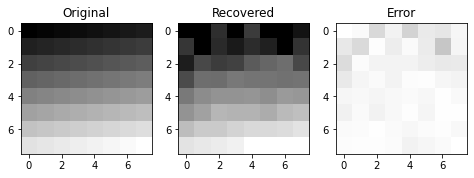

In [552]:
fig = plt.figure(figsize=(8,3))
columns = 3
rows = 1
for (i,imges,title) in zip(range(1, columns*rows +1), [img, img_rec, error], ["Original", "Recovered", "Error"]):
    fig.add_subplot(rows, columns, i)
    plt.imshow(imges, cmap='gray', vmin=0, vmax=255)
    plt.title(title)

plt.savefig("images/comparison8x8.jpg")
plt.show()